<a href="https://colab.research.google.com/github/kiteday/AI_contents/blob/main/customLoad_%EC%9D%91%EC%9A%A9.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 커스텀 데이터셋 로딩
* 이미지 왜곡 수정
  * resize 할 때 일어나는 강제 왜곡을 수정

## 라이브러리 임포트

In [3]:
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.utils.data as data
import torchvision.datasets as dset
import torchvision.transforms as transforms
from torch.utils.data import Dataset,DataLoader

from torch.autograd import Variable

from PIL import Image

In [4]:
imgsize = 128

In [5]:
img_dir = "/content/drive/MyDrive/AI_content/my_catdog/train/"

In [6]:
import os

def MyGetInfoFromFolder(ipath):
  classes = sorted(os.listdir(ipath))
  class_to_idx = {}
  length = 0
  total_file_list=[]
  total_label = []

  for i, c in enumerate(classes):
    class_to_idx.update({c: i})

    file_list = sorted(os.listdir(ipath + "/"+ c))
    length += len(file_list)

    for f in file_list:
      total_file_list.append(ipath + c + "/" +f)
      total_label.append(i)
  
  return classes, class_to_idx, length, total_file_list, total_label

In [7]:
"""
이미지를 최대한 크게 정사각형으로 자르기 위한 함수
-> 왜곡 없이!!
"""

def CropImgSquare(img):
  small_len = min(img.width, img.height)
  
  # 중심계산
  cx, cy = img.width/2, img.height/2
  
  # 단축의 반 계산
  d = small_len/2

  # PIL image crop (Google search)
  (left, upper, right, lower) = (cx-d, cy-d, cx+d, cy+d)
  img = img.crop((left, upper, right, lower))

  return img

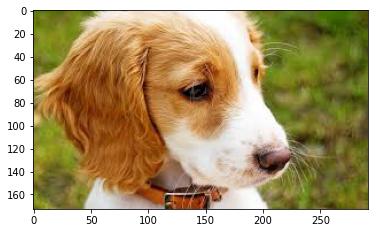

292 173


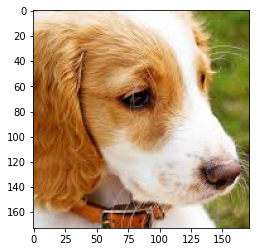

172 173


In [8]:
"""
샘플 데이터로 커스텀 함수가 잘 작성되었는지 확인
"""
# 원본 이미지 출력
dir = img_dir + "dogs/images (2).jpeg"
img = Image.open(dir)
plt.imshow(img)
plt.show()

print(img.width, img.height)

# 크롭된 이미지 출력
img = CropImgSquare(img)

plt.imshow(img)
plt.show()

print(img.width, img.height)

In [9]:
def MyGetInfoFromFolder(ipath):
  classes = sorted(os.listdir(ipath))
  class_to_idx = {}
  length = 0
  total_file_list=[]
  total_label = []

  for i, c in enumerate(classes): # class folder
    class_to_idx.update({c:i})

    file_list = sorted(os.listdir(ipath + "/"+ c))
    length += len(file_list)

    for f in file_list: # image file list
      total_file_list.append(ipath + c + "/" +f)
      total_label.append(i)
  
  return classes, class_to_idx, length, total_file_list, total_label

In [14]:
"""
* Custumized dataset
  폴더의 영상을 가져올 수 있는 클래스 객체 -> dset.ImageFolder 역할

* 입력변수
  ipath : 데이터가 들어있는 경로
  imgsizr : 기준이 되는 이미지 크기

* 응용
  비율변경없이 최대한 크게 정사각형으로 자르고, 크기 맞추기

* yhk 클래스 : Dataset_folder 
"""
class MyImageFolder(Dataset):
  def __init__(self, ipath, transform=transforms.ToTensor()):
    self.classes, self.class_to_idx, self.length, self.files, self.labels = MyGetInfoFromFolder(ipath)
    self.root_dir = ipath
    self.transform=transform

  def __len__(self):
    return self.length # 이 path에 있는 모든 폴더의 모든 이미지 개수

  def __getitem__(self, idx):
    # original image
    img = Image.open(self.files[idx])

    # 예외처리-mode
    if img.mode != "RGB":
      img = img.convert(mode="RGB")

    # 이미지 조정
    img = self.transform(img)

    # label
    label = self.labels[idx]

    return img, label

In [15]:
my_train = MyImageFolder(img_dir, 
                         transforms.Compose([transforms.Resize((imgsize, imgsize)),
                                                      transforms.ToTensor()]))

In [16]:
nclass = len(my_train.classes)
print("# of classes(클래스 개수): %d" %nclass)

print("클래스 이름 : ", my_train.classes)
print("클래스별 인덱스 : ", my_train.class_to_idx)
print("my_train 개수 : ", my_train.__len__())

# of classes(클래스 개수): 2
클래스 이름 :  ['cats', 'dogs']
클래스별 인덱스 :  {'cats': 0, 'dogs': 1}
my_train 개수 :  10


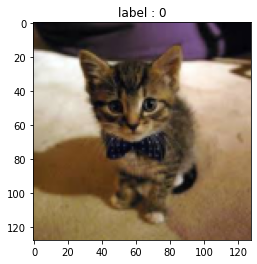

(128, 128, 3)


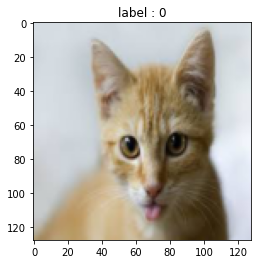

(128, 128, 3)


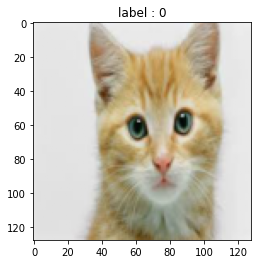

(128, 128, 3)


In [17]:
for i in range(3):
  img = my_train[i][0].numpy()
  img = np.transpose(img, (1,2,0))

  plt.title("label : %d" %my_train[i][1])
  plt.imshow(img)
  plt.show()

  print(img.shape)

데이터 로더

In [18]:
batch_size = 5

In [19]:
train_loader = data.DataLoader(my_train, batch_size=batch_size,
                               shuffle=False, num_workers=2,
                               drop_last = True)

[0]
한 번에 로드되는 데이터 크기: 5
torch.Size([5, 3, 128, 128])
torch.Size([5])


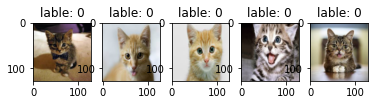

[1]
한 번에 로드되는 데이터 크기: 5
torch.Size([5, 3, 128, 128])
torch.Size([5])


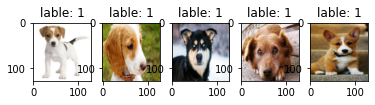

In [20]:
n = 5 # 샘플로 그려볼 데이터 개수

for i, [imgs, labels] in enumerate(train_loader):  # batch_size 만큼

  print("[%d]" %i)
  print("한 번에 로드되는 데이터 크기:", len(imgs))

  x = Variable(imgs).cuda()
  y_ = Variable(labels).cuda()

  print(x.shape)
  print(y_.shape)

  # 그리기
  for j in range(n):
    img = imgs[j].numpy() # image 타입-> numpy로 변환 (3, width, height)
    img = np.transpose(img, (1,2,0)) # (3, width, height) -> (width, heigh, 3)

    plt.subplot(1, n, j+1) # (1,3) 형태 플랏의 j번떄 위치에 그림
    plt.imshow(img)
    plt.title("lable: %d" %labels[j])
  plt.show()